In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [12]:
data= pd.read_csv('QVI_data.csv')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [14]:
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')
data.dropna(subset=['DATE'], inplace=True)

In [15]:
data['YEAR_MONTH'] = data['DATE'].dt.to_period('M')
store_monthly_performance = data.groupby(['STORE_NBR', 'YEAR_MONTH']).agg(
    TOTAL_SALES = ('TOT_SALES', 'sum'),
    N_CUSTOMERS = ('LYLTY_CARD_NBR', 'nunique'),
    N_TRANSACTIONS = ('TXN_ID', 'nunique'),
    TOTAL_PROD_QTY = ('PROD_QTY', 'sum')
).reset_index()

store_monthly_performance['YEAR_MONTH'] = store_monthly_performance['YEAR_MONTH'].dt.to_timestamp()

store_monthly_performance['AVG_TRANSACTIONS_PER_CUSTOMER'] = store_monthly_performance['N_TRANSACTIONS'] / store_monthly_performance['N_CUSTOMERS']
store_monthly_performance['UNITS_PER_CUSTOMER'] = store_monthly_performance['TOTAL_PROD_QTY'] / store_monthly_performance['N_CUSTOMERS']
store_monthly_performance['AVG_PRICE_PER_UNIT'] = store_monthly_performance['TOTAL_SALES'] / store_monthly_performance['TOTAL_PROD_QTY']

print(store_monthly_performance.head(10))


   STORE_NBR YEAR_MONTH  TOTAL_SALES  N_CUSTOMERS  N_TRANSACTIONS  \
0          1 2018-07-01        206.9           49              52   
1          1 2018-08-01        176.1           42              43   
2          1 2018-09-01        278.8           59              62   
3          1 2018-10-01        188.1           44              45   
4          1 2018-11-01        192.6           46              47   
5          1 2018-12-01        189.6           42              47   
6          1 2019-01-01        154.8           35              36   
7          1 2019-02-01        225.4           52              55   
8          1 2019-03-01        192.9           45              49   
9          1 2019-04-01        192.9           42              43   

   TOTAL_PROD_QTY  AVG_TRANSACTIONS_PER_CUSTOMER  UNITS_PER_CUSTOMER  \
0              62                       1.061224            1.265306   
1              54                       1.023810            1.285714   
2              75       

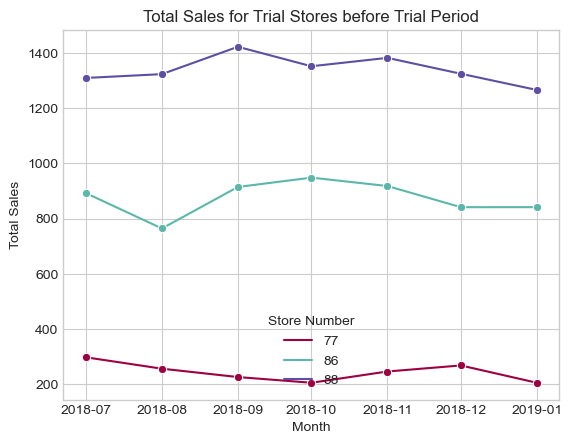

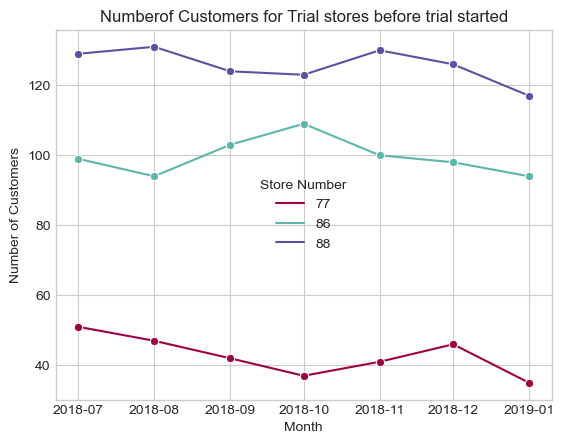

In [16]:
trial_stores = [77,86,88]

trail_start_month = pd.to_datetime('2019-02-01')
trial_end_month = pd.to_datetime('2019-04-30')

pre_trial_data = store_monthly_performance[store_monthly_performance['YEAR_MONTH'] < trail_start_month]

#Total Sales for trial stores in the pre-trial 
plt.style.use('seaborn-v0_8-whitegrid')
sns.lineplot(data = pre_trial_data[pre_trial_data['STORE_NBR'].isin(trial_stores)], x = 'YEAR_MONTH', y= 'TOTAL_SALES', hue = 'STORE_NBR', marker = 'o', palette = 'Spectral')
plt.title('Total Sales for Trial Stores before Trial Period')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number')
plt.show()

#Number of Customers for trail stores in the pre trial period
sns.lineplot(data = pre_trial_data[pre_trial_data['STORE_NBR'].isin(trial_stores)], x = 'YEAR_MONTH', y = 'N_CUSTOMERS', hue = 'STORE_NBR', marker = 'o', palette = 'Spectral')
plt.title('Numberof Customers for Trial stores before trial started')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend(title = 'Store Number')
plt.show()


Top 5 control candidates for Store 77 based on TOTAL_SALES correlation:
  Store 31: Correlation = 1.0000
  Store 11: Correlation = 1.0000
  Store 71: Correlation = 0.9141
  Store 233: Correlation = 0.9038
  Store 119: Correlation = 0.8677
Best control store for 77 based on TOTAL_SALES: 31
Top 5 control candidates for Store 86 based on TOTAL_SALES correlation:
  Store 31: Correlation = 1.0000
  Store 155: Correlation = 0.8779
  Store 132: Correlation = 0.8465
  Store 240: Correlation = 0.8251
  Store 222: Correlation = 0.7951
Best control store for 86 based on TOTAL_SALES: 31
Top 5 control candidates for Store 88 based on TOTAL_SALES correlation:
  Store 159: Correlation = 0.9032
  Store 204: Correlation = 0.8858
  Store 134: Correlation = 0.8643
  Store 1: Correlation = 0.8136
  Store 253: Correlation = 0.8118
Best control store for 88 based on TOTAL_SALES: 159
{77: 31, 86: 31, 88: 159}


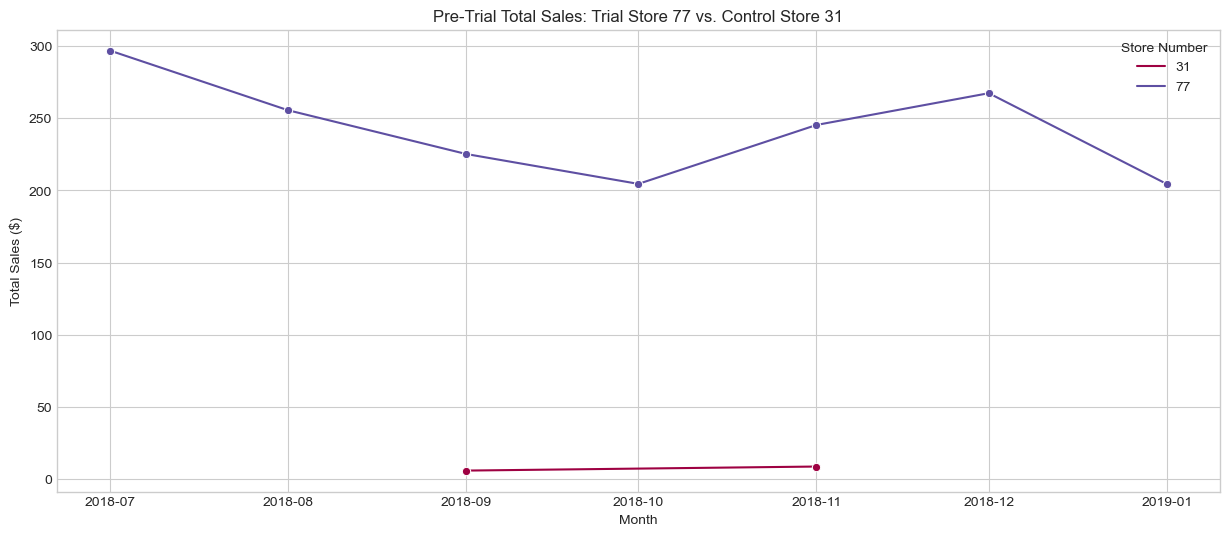

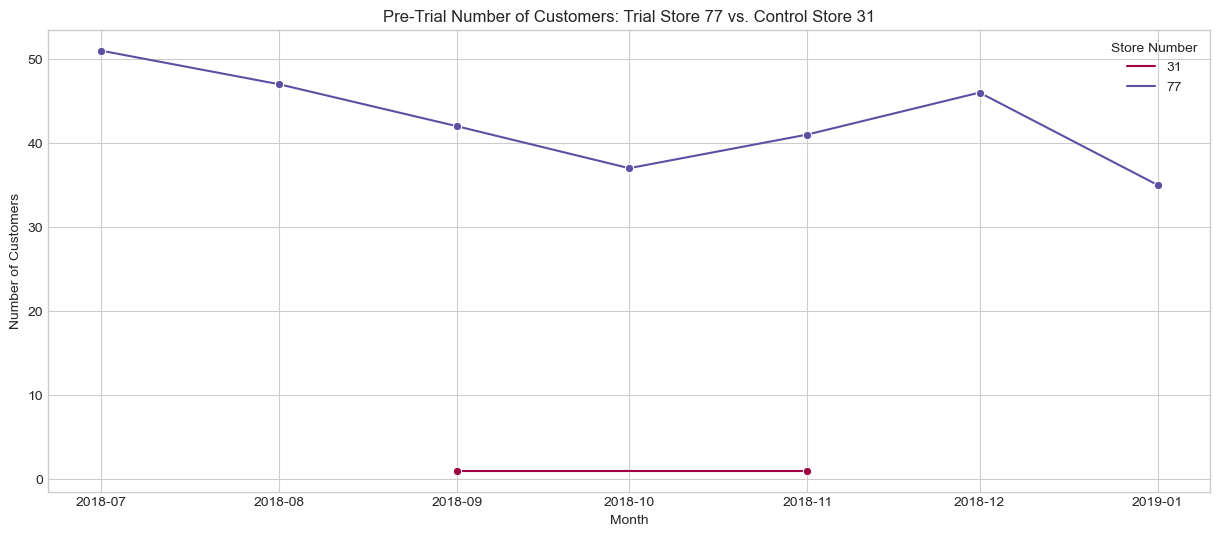

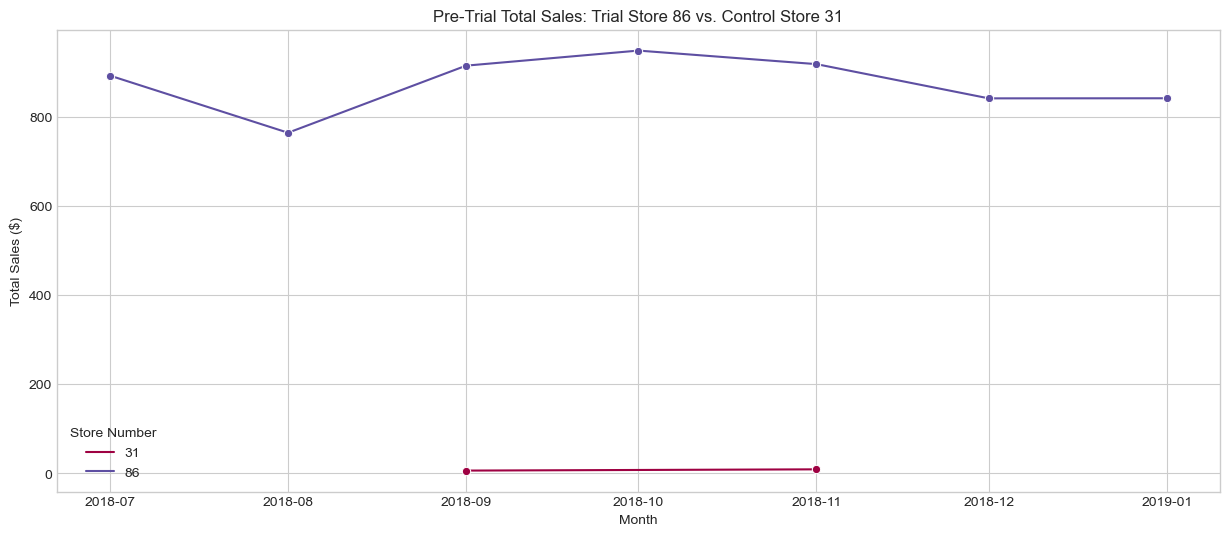

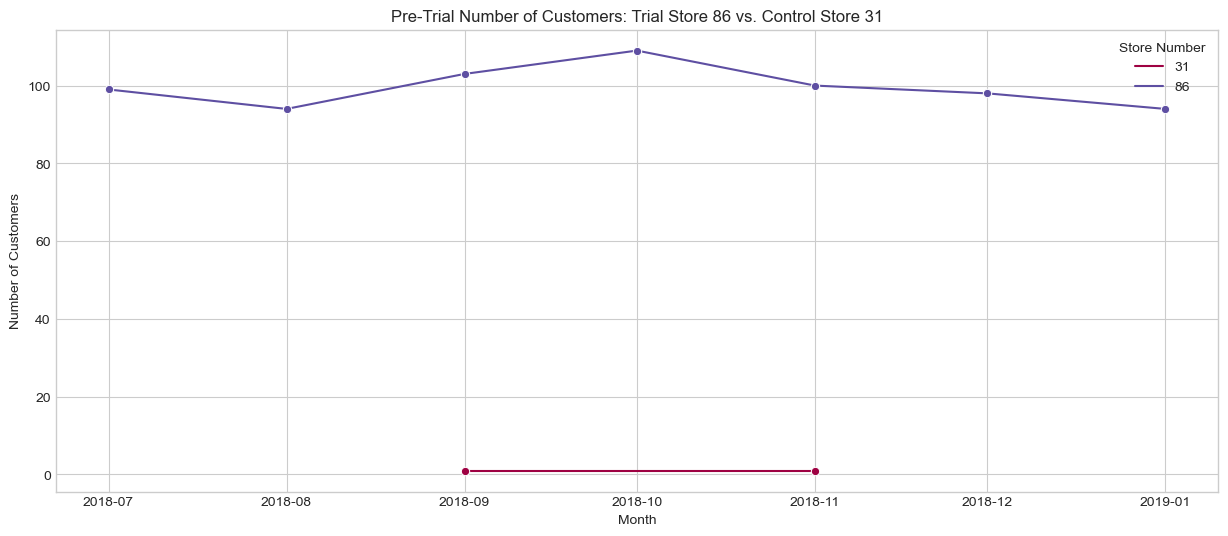

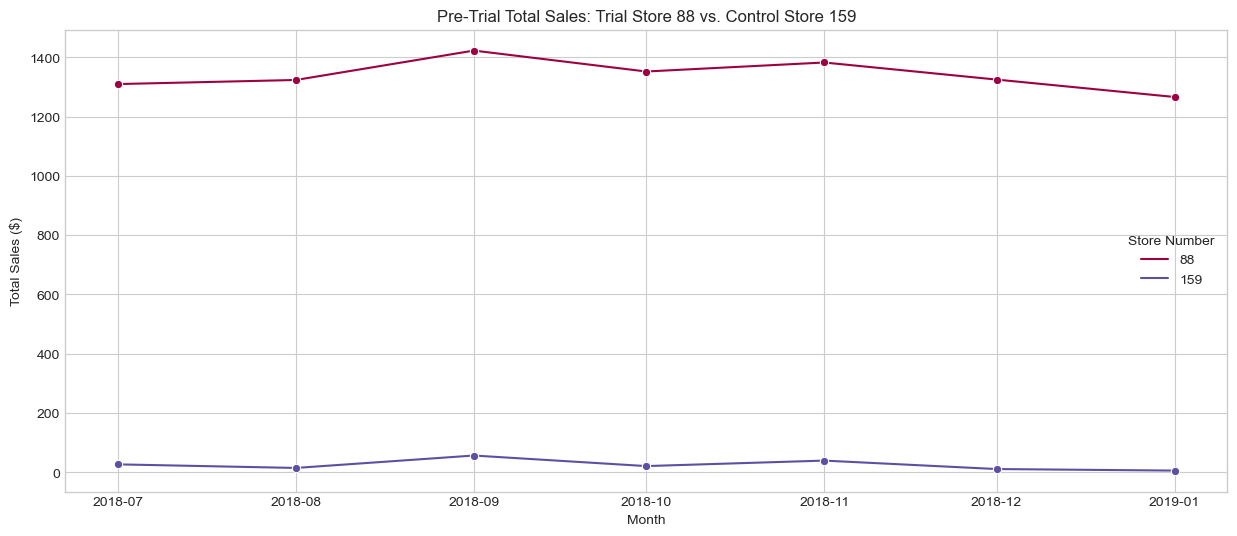

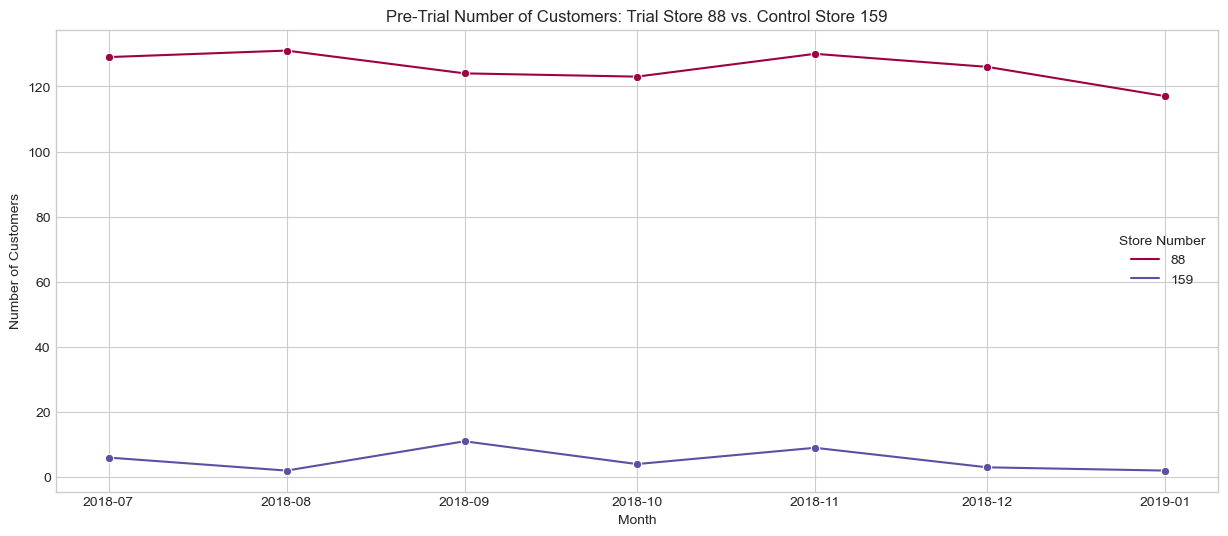

In [17]:
def find_control_store(trial_store_nbr, metric='TOTAL_SALES', n_candidates=5):
    trial_store_pre_trial = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store_nbr].set_index('YEAR_MONTH')
    trial_store_metric = trial_store_pre_trial[metric]

    other_stores = pre_trial_data[~pre_trial_data['STORE_NBR'].isin(trial_stores)]['STORE_NBR'].unique()

    correlations = {}
    for control_store_nbr in other_stores:
        control_store_pre_trial = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store_nbr].set_index('YEAR_MONTH')
        control_store_metric = control_store_pre_trial[metric]

        common_dates = trial_store_metric.index.intersection(control_store_metric.index)
        if len(common_dates) > 1:
            corr, _ = pearsonr(trial_store_metric.loc[common_dates], control_store_metric.loc[common_dates])
            correlations[control_store_nbr] = corr
        else:
            correlations[control_store_nbr] = np.nan

    sorted_correlations = sorted(
        [(corr, store) for store, corr in correlations.items() if not np.isnan(corr)],
        reverse=True
    )

    print(f"Top {n_candidates} control candidates for Store {trial_store_nbr} based on {metric} correlation:")
    for corr, store in sorted_correlations[:n_candidates]:
        print(f"  Store {store}: Correlation = {corr:.4f}")

    if sorted_correlations:
        best_control_store = sorted_correlations[0][1]
        print(f"Best control store for {trial_store_nbr} based on {metric}: {best_control_store}")
        return best_control_store
    else:
        print(f"Could not find a suitable control store for {trial_store_nbr}.")
        return None

control_store_mapping = {}
for trial in trial_stores:
    control_sales = find_control_store(trial, metric='TOTAL_SALES')
    control_store_mapping[trial] = control_sales
print(control_store_mapping)

for trial, control in control_store_mapping.items():
    if control:
        plt.figure(figsize=(15, 6))

        # Filter data for both trial and control store in pre-trial period
        plot_data = pre_trial_data[pre_trial_data['STORE_NBR'].isin([trial, control])]

        sns.lineplot(data=plot_data, x='YEAR_MONTH', y='TOTAL_SALES', hue='STORE_NBR', marker='o', palette = 'Spectral')
        plt.title(f'Pre-Trial Total Sales: Trial Store {trial} vs. Control Store {control}')
        plt.xlabel('Month')
        plt.ylabel('Total Sales ($)')
        plt.legend(title='Store Number')
        plt.show()

        plt.figure(figsize=(15, 6))
        sns.lineplot(data=plot_data, x='YEAR_MONTH', y='N_CUSTOMERS', hue='STORE_NBR', marker='o', palette = 'Spectral')
        plt.title(f'Pre-Trial Number of Customers: Trial Store {trial} vs. Control Store {control}')
        plt.xlabel('Month')
        plt.ylabel('Number of Customers')
        plt.legend(title='Store Number')
        plt.show()

In [18]:
control_scaling_factors = {}
for trial, control in control_store_mapping.items():
    if control:
        # fixed variable name (trial instead of trail) and guard against division by zero
        trial_sales_pre_trial = pre_trial_data[pre_trial_data['STORE_NBR'] == trial]['TOTAL_SALES'].sum()
        control_sales_pre_trial = pre_trial_data[pre_trial_data['STORE_NBR'] == control]['TOTAL_SALES'].sum()

        trial_customers_pre_trial = pre_trial_data[pre_trial_data['STORE_NBR'] == trial]['N_CUSTOMERS'].sum()
        control_customers_pre_trial = pre_trial_data[pre_trial_data['STORE_NBR'] == control]['N_CUSTOMERS'].sum()

        sales_factor = np.nan
        customers_factor = np.nan
        if control_sales_pre_trial != 0:
            sales_factor = trial_sales_pre_trial / control_sales_pre_trial
        if control_customers_pre_trial != 0:
            customers_factor = trial_customers_pre_trial / control_customers_pre_trial

        control_scaling_factors[trial] = {
            'SALES_FACTOR': sales_factor,
            'CUSTOMERS_FACTOR': customers_factor
        }
print("\n--- Control Store Scaling Factors ---")
print(control_scaling_factors)



--- Control Store Scaling Factors ---
{77: {'SALES_FACTOR': 114.79729729729729, 'CUSTOMERS_FACTOR': 149.5}, 86: {'SALES_FACTOR': 413.50337837837833, 'CUSTOMERS_FACTOR': 348.5}, 88: {'SALES_FACTOR': 53.49828962371722, 'CUSTOMERS_FACTOR': 23.783783783783782}}



--- Trial Period Comparison ---

Comparing Trial Store 77 with Control Store 31:


NameError: name 'trial_start_month' is not defined

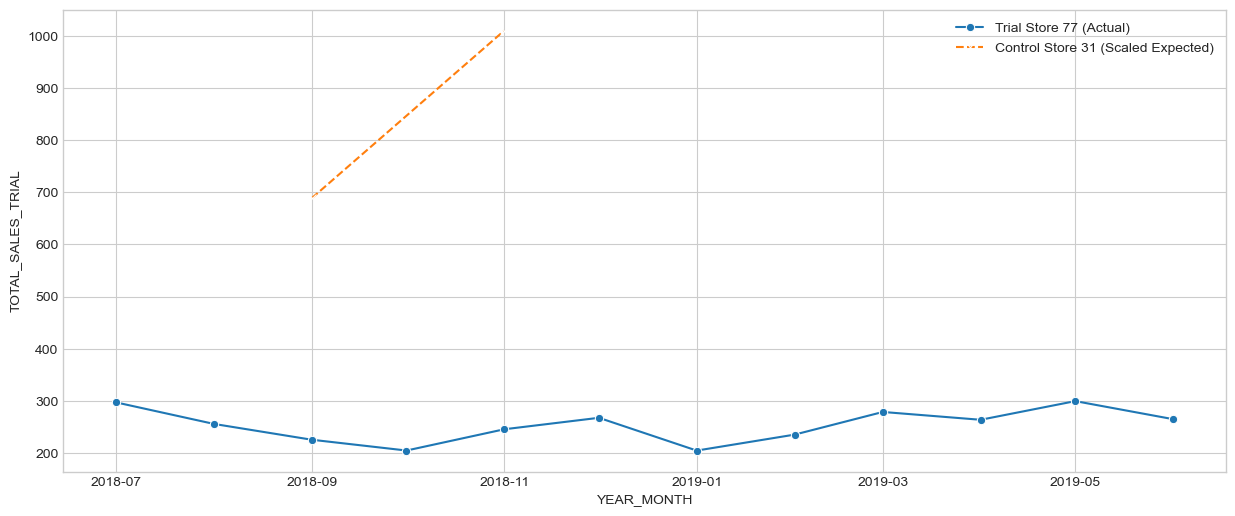

In [ ]:
#full periodpincludingepre-trial,rtrial,daed posr-tiiad including including pre pre--trial,trial, trial, trial, and and post post-trial-
full_period_datatrial =
full_period_data store_monthly_performance.copy() =

# store_monthly_performance.copy() Alias

# the Alias correctly the- correctlynamed- variablenamed (typo variable in (typo earlier in cell: "trail_start_month") earlier
# cell: so "trail_start_month") the
# rest so of the the code rest can of use the "trial_start_month" code as can intended. use
try: "trial_start_month"
    trial_start_month as = intended. trial_start_month
try:  #
    trial_start_month if = already trial_start_month defined,  # keep if it
except already NameError: defined,
    trial_start_month keep = trail_start_month it

print("\n---
except Trial NameError: Period
    trial_start_month Comparison = --- trail_start_month")

for

print("\n trial,--- control in Trial control_store_mapping.items():
 Period Comparison ---")

for trial, control in control_store_mapping.items():
   if control:
full_period_data = store_monthly_performance.copy()

# Alias the correctly-named variable (typo in earlier cell: "trail_start_month")
# so the rest of the code can use "trial_start_month" as intended.
try:
    trial_start_month = trial_start_month  # if already defined, keep it
except NameError:
    trial_start_month = trail_start_month

print("\n--- Trial Period Comparison ---")

for trial, control in control_store_mapping.items():
        # Apply scaling factors to control store metrics
        sales_factor = control_scaling_factors[trial]['SALES_FACTOR']
        customers_factor = control_scaling_factors[trial]['CUSTOMERS_FACTOR']
        
        control_data_full['SCALED_TOTAL_SALES'] = control_data_full['TOTAL_SALES'] * sales_factor
        control_data_full['SCALED_N_CUSTOMERS'] = control_data_full['N_CUSTOMERS'] * customers_factor

        # Merge trial store data with scaled control data for easy comparison
        trial_control_compare = full_period_data[full_period_data['STORE_NBR'] == trial].copy()
        trial_control_compare = trial_control_compare.merge(
            control_data_full[['YEAR_MONTH', 'SCALED_TOTAL_SALES', 'SCALED_N_CUSTOMERS']],
            on='YEAR_MONTH',
            how='left',
            suffixes=('_TRIAL', '_CONTROL_SCALED')
        )

        # Rename trial columns so plotting and later calculations reference consistent names
        # (merge did not automatically add a suffix to the trial's columns)
        trial_control_compare.rename(
            columns={'TOTAL_SALES': 'TOTAL_SALES_TRIAL', 'N_CUSTOMERS': 'N_CUSTOMERS_TRIAL'},
            inplace=True
        )

        # Plot comparison of total sales
        plt.figure(figsize=(15, 6))
        sns.lineplot(x='YEAR_MONTH', y='TOTAL_SALES_TRIAL', data=trial_control_compare, label=f'Trial Store {trial} (Actual)', marker='o')
        sns.lineplot(x='YEAR_MONTH', y='SCALED_TOTAL_SALES', data=trial_control_compare, label=f'Control Store {control} (Scaled Expected)', marker='x', linestyle='--')
        
        # Highlight trial period
        plt.axvspan(trial_start_month, trial_end_month + pd.DateOffset(months=1, days=-1), color='grey', alpha=0.2, label='Trial Period')
        
        plt.title(f'Total Sales Comparison: Trial Store {trial} vs. Scaled Control Store {control}')
        plt.xlabel('Month')
        plt.ylabel('Total Sales ($)')
        plt.legend()
        plt.show()

        # Plot comparison of number of customers
        plt.figure(figsize=(15, 6))
        sns.lineplot(x='YEAR_MONTH', y='N_CUSTOMERS_TRIAL', data=trial_control_compare, label=f'Trial Store {trial} (Actual)', marker='o')
        sns.lineplot(x='YEAR_MONTH', y='SCALED_N_CUSTOMERS', data=trial_control_compare, label=f'Control Store {control} (Scaled Expected)', marker='x', linestyle='--')
        
        # Highlight trial period
        plt.axvspan(trial_start_month, trial_end_month + pd.DateOffset(months=1, days=-1), color='grey', alpha=0.2, label='Trial Period')
        
        plt.title(f'Number of Customers Comparison: Trial Store {trial} vs. Scaled Control Store {control}')
        plt.xlabel('Month')
        plt.ylabel('Number of Customers')
        plt.legend()
        plt.show()

        # Calculate percentage difference during trial period
        trial_period_compare = trial_control_compare[
            (trial_control_compare['YEAR_MONTH'] >= trial_start_month) &
            (trial_control_compare['YEAR_MONTH'] <= trial_end_month)
        ].copy()

        # Handle cases where scaled control sales might be zero (e.g. for a month) to avoid division by zero
        trial_period_compare['SALES_DIFF_%'] = (
            (trial_period_compare['TOTAL_SALES_TRIAL'] - trial_period_compare['SCALED_TOTAL_SALES']) / 
            trial_period_compare['SCALED_TOTAL_SALES'].replace(0, np.nan) # Replace 0 with NaN
        ) * 100

        trial_period_compare['CUSTOMERS_DIFF_%'] = (
            (trial_period_compare['N_CUSTOMERS_TRIAL'] - trial_period_compare['SCALED_N_CUSTOMERS']) / 
            trial_period_compare['SCALED_N_CUSTOMERS'].replace(0, np.nan)
        ) * 100
        
        print("\nTrial Period Performance (Feb 2019 - Apr 2019):")
        print(trial_period_compare[['YEAR_MONTH', 'TOTAL_SALES_TRIAL', 'SCALED_TOTAL_SALES', 'SALES_DIFF_%',
                                     'N_CUSTOMERS_TRIAL', 'SCALED_N_CUSTOMERS', 'CUSTOMERS_DIFF_%']])

        # Aggregate average percentage difference during trial
        avg_sales_diff = trial_period_compare['SALES_DIFF_%'].mean()
        avg_customers_diff = trial_period_compare['CUSTOMERS_DIFF_%'].mean()
        
        print(f"\nAverage % difference in sales during trial: {avg_sales_diff:.2f}%")
        print(f"Average % difference in customers during trial: {avg_customers_diff:.2f}%")

        # Test for statistical significance (e.g., t-test if normally distributed, or simpler check)
        # Given the monthly data points are few (3 months), a formal t-test might not be robust.
        # We can observe the magnitude of the difference visually and with the percentage.
        # If the differences are substantial and consistent, it's a strong indicator.

        # Additional insights: Price per unit and Units per customer during trial
        trial_store_metrics_trial_period = data[
            (data['STORE_NBR'] == trial) &
            (data['DATE'] >= trial_start_month) &
            (data['DATE'] <= trial_end_month + pd.DateOffset(months=1, days=-1))
        ].copy()
        
        control_store_metrics_trial_period = data[
            (data['STORE_NBR'] == control) &
            (data['DATE'] >= trial_start_month) &
            (data['DATE'] <= trial_end_month + pd.DateOffset(months=1, days=-1))
        ].copy()

        # Recalculate these more granularly for the trial period
        trial_avg_price_per_unit = (trial_store_metrics_trial_period['TOT_SALES'].sum() / 
                                   trial_store_metrics_trial_period['PROD_QTY'].sum())
        trial_units_per_customer = (trial_store_metrics_trial_period['PROD_QTY'].sum() / 
                                    trial_store_metrics_trial_period['LYLTY_CARD_NBR'].nunique())

        control_avg_price_per_unit = (control_store_metrics_trial_period['TOT_SALES'].sum() / 
                                      control_store_metrics_trial_period['PROD_QTY'].sum())
        control_units_per_customer = (control_store_metrics_trial_period['PROD_QTY'].sum() / 
                                      control_store_metrics_trial_period['LYLTY_CARD_NBR'].nunique())
        
        print(f"\nTrial Store {trial} (Trial Period):")
        print(f"  Avg Price Per Unit: ${trial_avg_price_per_unit:.2f}")
        print(f"  Units Per Customer: {trial_units_per_customer:.2f}")

        print(f"Control Store {control} (Trial Period):")
        print(f"  Avg Price Per Unit: ${control_avg_price_per_unit:.2f}")
        print(f"  Units Per Customer: {control_units_per_customer:.2f}")